# Optimal control and reinforcement learning with the inverted pendulum

the goal of this exercise series is to gain practical experience implementing with value iteration, policy iteration and q-learning algorithms.

In [1]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
import pickle
import random

First we define a few simple functions to display results

In [2]:
def animate_pendulum(x, dt):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation (with deltaT=0.1s)
    """
    
    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    plotx = x[:,::steps]
    
    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)
    
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])
        
        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [3]:
def plot_results(pend, value_function, policy, animate=True):
    """
    This function plots the results. It displays the value function, the policy for all states.
    Then it integrates the pendulum from state [0,0] and displays the states and control as a function of time
    Finally it shows an animation of the result
    """
    x0 = np.array([0.,0.])

    x, u = pend.simulate(x0, policy, 20)

    plt.figure(figsize=[6,6])
    plt.imshow(value_function.reshape((pend.nq, pend.nv)), extent=[0., 2*np.pi, -pend.v_max, pend.v_max], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')

    plt.figure(figsize=[6,6])
    plt.imshow(policy.reshape((pend.nq, pend.nv)), extent=[0., 2*np.pi, -pend.v_max, pend.v_max], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')

    time = np.linspace(0.,20., len(x[0,:]))
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time,x[0,:])
    plt.ylabel('angle')
    plt.subplot(3,1,2)
    plt.plot(time,x[1,:])
    plt.ylabel('velocity')
    plt.subplot(3,1,3)
    plt.plot(time[:-1],u)
    plt.ylabel('control')
    if animate:
        animate_pendulum(x, pend.delta_t)

## Defining the pendulum

Here we define a class that provides functions to work with the inverted pendulum
This will be used by the value iteration algorithm and also to test the resulting policies

In [4]:
class DiscretePendulum:
    """
    This class describes a "discretized" inverted pendulum and provides some helper functions
    to use for value/policy iteration and q-learning with a table
    
    Rationale: as we will use the pendulum with algorithms using tables, we will handle a
    state (i.e. position and velocity of the pendulum) which will be discretized and for every
    state we will associate an index that enables to address the table (index is an integer from
    0 to number_of_q * number_of_v -1)
    """
    
    def __init__(self, nq=50, nv=50, nu=3, u_max=5., v_max=6.0):
        """
        constructor of the class, takes as input desired discretization number
        nq (for angle), nv (for angular velocity) and nu (for control) and the maximum control
        and angular velocity
        """
        #store discretization information
        self.nq=nq
        self.nv=nv
        self.nu = nu
        self.v_max = v_max
        
        # create lookup tables for discretized states
        self.u = np.linspace(-u_max, u_max, self.nu)
        self.q = np.linspace(0., 2*np.pi, self.nq, endpoint=False)
        self.v = np.linspace(-v_max, v_max, self.nv)
        
        #the total number of discretized states
        self.num_states = self.nq * self.nv
        
        #gravity constant
        self.g=9.81

        #discretization step
        self.delta_t = 0.1
        #integration step / smaller than discretization step to ensure stability of integration
        self.dt = 0.01
        self.integration_ratio = int(self.delta_t/self.dt)
        
        # we pre-compute every possible transition and store the index of the transition
        # in a 2D table (for element address the state and second the control)
        self.next_state_index = np.empty([self.num_states, self.nu], dtype=np.int32)
        for i in range(self.num_states):
            for k in range(self.nu):
                x_next = self.step(self.get_states(i), self.u[k])
                self.next_state_index[i,k] = self.get_index(x_next)
            
            
    def step(self,x,u):
        """
        This function integrates the pendulum for one step of self.delta_t seconds using
        an inner integration step of self.dt (to ensure stable integration)
        
        Inputs:
        x: state of the pendulum (x,v) as a 2D numpy array
        u: control as a scalar number
        
        Output:
        the state of the pendulum as a 2D numpy array at the end of the integration
        """
        for i in range(self.integration_ratio):
            x_next = (x[0] + self.dt * x[1])%(2*np.pi)
            v_next = np.clip(x[1] + self.dt * (u-self.g*np.sin(x[0])), -self.v_max, self.v_max)
            x = np.array([x_next,v_next])
        return x
    
    def simulate(self, x0, policy, T):
        """
        This function simulates the pendulum of T seconds from initial state x0 using a discrete policy 
        
        Inputs:
        x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
        policy: a 1D array containing a discretized policy
        T: the time to integrate for
        
        Output:
        x (2D array) and u (1D array) containing the time evolution of states and control
        """
        horizon_length = int(T/self.delta_t)
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([horizon_length])
        for i in range(horizon_length):
            u[i] = policy[self.get_index(x[:,i])]
            x[:,i+1] = self.step(x[:,i], u[i])
        return x, u

    
    def get_index(self, x):
        """
        given an arbitrary 2D state (x) of the pendulum it returns the associated index, 
        for example to use to address a table
        """
        ind_q = np.argmin((x[0]-self.q)**2)
        ind_v = np.argmin((x[1]-self.v)**2)
        return ind_q + ind_v*self.nq
    
    def get_states(self, index):
        """
        given an index, it returns the associated discretized state of the pendulum as a 2D vector
        """
        iv,ix = np.divmod(index, self.nq)
        return np.array([self.q[ix], self.v[iv]])                

## Cost function

This is the instantaneous cost $$g(x,v,u) = 1000(1-\cos(x-\pi))^2 + 100 v^2 + u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls

In [5]:
def cost(x,u):
    """
    a cost function for the inverted pendulum
    """
    return 10000.*(1.-np.cos(x[0]-np.pi))**2 + 100.*x[1]**2 + 1.*u**2

## Value Iteration
The following class implements the value iteration algorithm as seen in the class. The algorithm is generic and could be used for any model. As a constructor, it gets a dynamic model (that needs to implement the same functions implemented by the pendulum class) and a cost function as define above.

In [6]:
class ValueIteration:
    """
    This class is used to implement value iteration and store the state of the value function and policy
    as we iterate
    """
    def __init__(self, model, cost, discount_factor=0.99):
        """
        receives as input a pendulum and cost function and potentially a discount factor
        """
        
        # value function stored as a 1D array (indexed as we indexed states in pendulum)
        self.value_function = np.zeros([model.num_states])
        # we also store the policy similarly
        self.policy = np.zeros([model.num_states])
        # references to the pendulum and cost function
        self.model = model
        self.cost = cost
        
        #discount factor for cost
        self.gamma = discount_factor
                
    def iterate(self, num_iter=1):
        """
        the main iteration of value iteration
        num_iter: maximum number of iterations to be performed. 
        
        If after an iteration the value function does not change (e.g. less thant 10e-5)
        the function returns and print success
        """
        for i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(self.model.num_states):
                #for each possible control input we compute the cost
                r = np.zeros([self.model.nu])
                for l in range(self.model.nu):
                    # the current states and control
                    x = self.model.get_states(j)
                    u = self.model.u[l]
                    # the index for the next state
                    next_index = self.model.next_state_index[j,l]
                    #compute the cost
                    r[l] = self.cost(x, u) + self.gamma*self.value_function[next_index]
                    
                # we take the smallest cost value to update the value function
                J_new[j] = np.min(r)
                #here we also store the policy (so we have it for later)
                self.policy[j] = self.model.u[np.argmin(r)]
                
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-5).all():
                print("CONVERGED after iteration " + str(i))
                break
            else:
                self.value_function = J_new.copy()
    

In [7]:
# we instantiate a pendulum with discretization 50x50 for angle q and velocity v and 3 actions
pendulum = DiscretePendulum(nq=50, nv=50, nu=3)

CONVERGED after iteration 1056


<IPython.core.display.Javascript object>


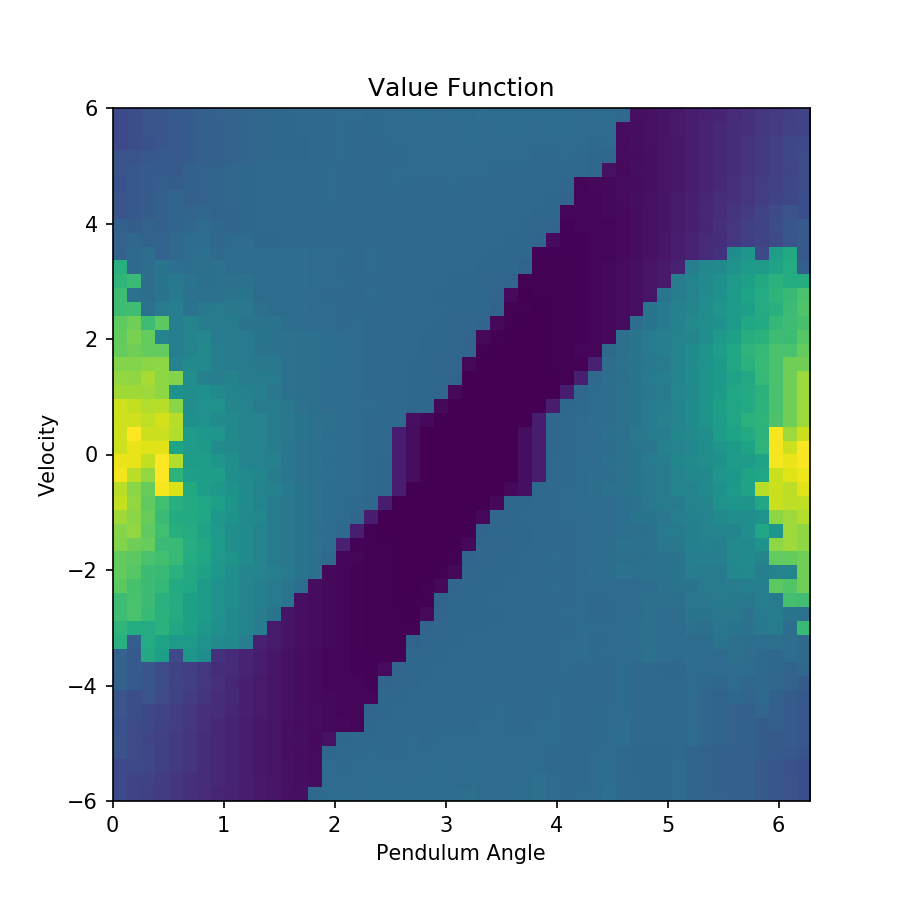

<IPython.core.display.Javascript object>


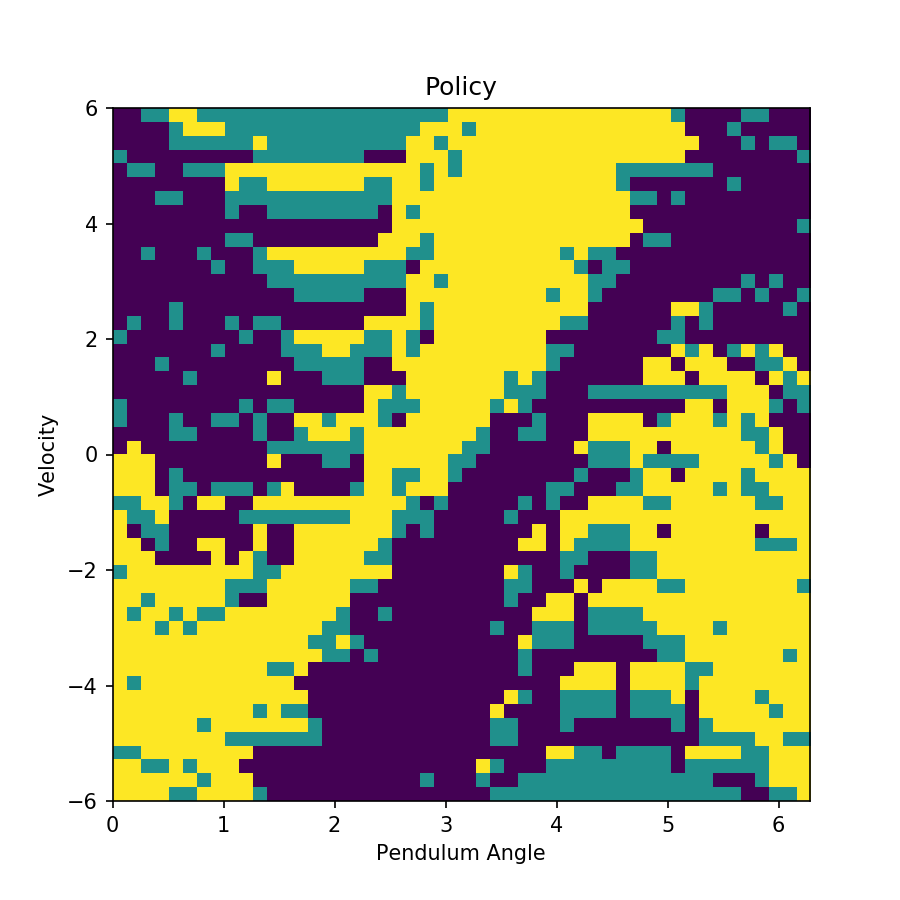

<IPython.core.display.Javascript object>


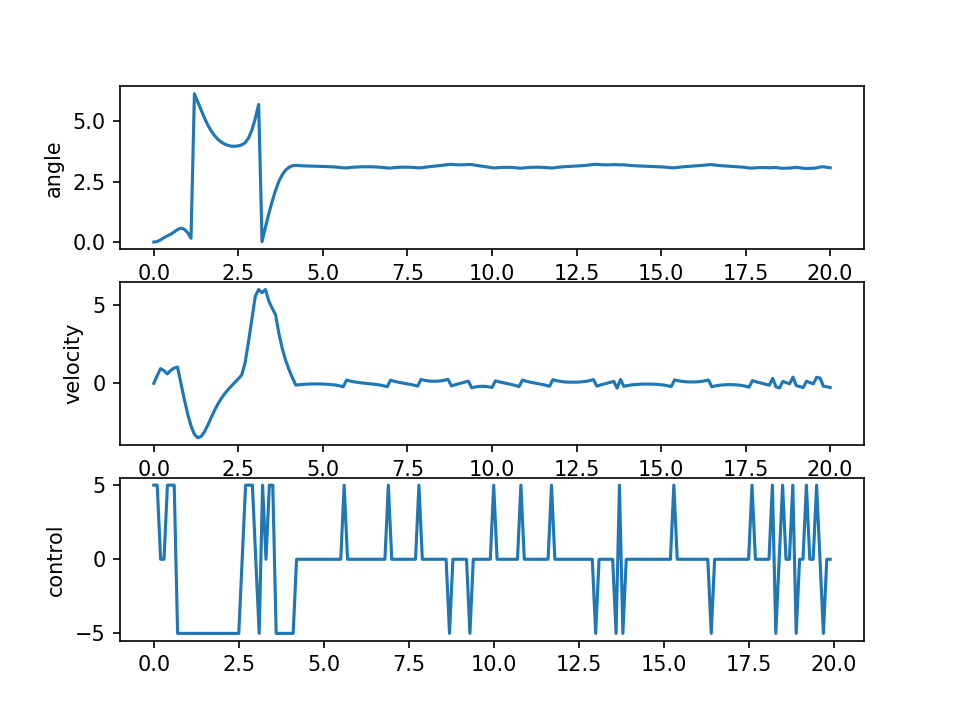

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAADGn21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0LZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZYZCdC/yYgAABXwAsgZkmelx
SROADzDHsnTdNPwqh0IYXPcgsx/VdOgPtpJk3xmz25oQD2NxIJATjjPFHtCPYSSyrz7P5apm+qGo
CaO0hQa9TgblAkEBRtsbJoJjDfyhjQSKoxTNex2bKxAqRTNoM297EWxml92F4SgqAa9lbwbZ8+3M
8l0TfdHNaygcBuoe/stRvUXLZinWJDX2fTyHC+vsg7SSDh9VCALo/f8LntmbRMOk0qgXCi/HjrLA
aDHF+z18yVLK2z74iGw43VhNdJn7sOk6H3E21bAuxha9GcFT2B/gDsnAFBY5gBiZPeVxVbYpe4QY
u/Qkmk29MQ1rmTd5w6tt8rxwNyDWYzoDXLAPOxYEu0cWoQcXPjpp4iBWBfo93KDgq6XQij4Oj1LG
DzySMr38uhgbYXdV91VBopGTufKSekk2ZkKOtbq4Kr/zM9vviogAubMfy1/YSD/ic+Z6ysW11mqE
aw28fkE07LoVANnt98/WFOh2kP4qKS2EOW2R/aA3Z7G+ebWAmpyGawSKOP74xuxvFb5q1HlG8DH3
O6BFg3INvuHOb9LHOidxhtyJ3CtFzNDKZ6xn6mDvAAWWi6X5dO/wM3+9oH84RnZyXvVBZTxz37Y9
CWBZs8SWxmeLauVtCDCWXGmfqsrX46rQWMB4u9lYrAKwMZuizVue6UnRPHemBWdGnkbqAAADACD0
ANcQ40/Hq0+C/IVB7E6E8/0hxRRcvjG6SzMaY96vEYW1Xq25smcnLCILhZkmJIeYSAGekCyFQZjX
eMIfOxfYRRQ2+M3jcOu+XI9+1Cai1TA2ZnqILS7wLes/5PvPhzldRLw6Mi6AF/02jJWYOCfAv64s
q38qd/OkSMhM82heKkah1t6+MlfPfYXqsKbxXmMBfmR+shR+zWjzB7+tfJnCv62/jd1fmY1Oq8bJ
7OFXCihML8JdKGSzHTrQZczZkk/johxYB/8xdIU4DKDA8SZO/kX0YZEeZbh/6rTv0FyBaWenz1gn
3AFNvBHSAuhCzEXw8H1OFdZUCAwQjanBI8bb/HvHTDJadZ1IkBd9i/VNYTQpwWEuD4q55BwOp+vj
I73jzRjDtodLb6Jhu5DC0+mUDRbE0GBV/7bJ4cLyI6bS4lEOwbhSnD/ltcmKVqujIjO2TOC6aWuA
kErJNbcQ+OceZuxIJK3T0O462gjyRqXmrsiqS5A2gPUprog2ww+Q7JJ0xDnA6CZbYVsNmapBUivR
nU6TwtUliRgpf20GSDYqiS3GLJ+Q/zQTV4HmonyuzVz+yMJEwphgndExt4iQqRh1Wu5pdTRzDCzF
75n2ZIBMO2utJBRazvHD1RNFG/i/Av0JncoT0yosk1tnGz9/bx8cvrWudJUA63w0GFhTN9FfbhNL
EG0Rj3G4wzRDPhYg2OPrP8c2HzJX42T4f+F4sDS0jcxwymJ3iXWwWaafMFmWUzOwwt+fcXZXeB4Y
xTaz8WGMe1cD+tpLchd06BJhO4gdjzpAc8LTaQQWjIWrSWJfYAK4kKq+n8T+MzEQgcRlHK+L86/U
IESkVh6m0Dv5k+pUXYVwvlBPk2it2qHJZ4cVSVN78MOBsfsZqW+frLmEkRTqeQhBAkuN5pRse518
Geh+QDKHH7ThdcPQBQiL7weihKKpeyxW0MJrP7Y1ASYpcfq9W+Lwi26bS4MuqnEA1sLTUllHcY40
Iv9cpX3OC9/U8yxOnaqJJpEsfffkS5VzYpcpUpSeS29Dz+qIO0poJU8GNUZ2/VfBuzrQ35xLema4
h9hsJvW7xwjZioGWSX+6JnlShwM5P6NYiJRUhFMP/ao3FPvxJlrdjsaXW2fyO3vAIihUh+wTKqdv
mP096PxP899l2CZObIBq/JAT/ez5oy5DK5CWejamb1LNbd7mVahkiZd7jdfiywtBSedvXeWRW8Fx
sAkjnyejc8pycyLKeuEc2NO8JzzhdDybjKLz0wz8uL/AaOBvaTZaoNHAKp8a6ZpQATl93TWVNWdm
dAdO15HXmW5K4OcwpHNusn863svdBHI7+UoHc9y23XpVasjfICQt/3T3tYnjReriz1Yh0VayHeGV
UuJNIk0s5JrrKzGTgwbiiVqw0hg9P4W3Hgizv7HA2BcPgR3KIfmJgL12E9gFjiNDngaPC0OSy/rC
Kmr7RVCTVT1bALoT+2//udVAS4U90TiaAgxNY3x9swfqmw/Pw7aTOvDPKpNMEnNfpH85NBMZzag3
yd3H+qRMI7I2lNz7RuNro6WyUlQUikrfLuWCqDOYG6pe0BeZDxjbBvSQSWfMBqmCZg1gQE43Cdx+
KF3fBacf+kJWL7zMgXOcHJWxA/T0yAAAM9+FDHX+gLg8OkAIgAAAAwEq8r5Z//8ZR9Fv68XqCVIC
0tV+X1wfVWdnC0Z4L6VKHb5d660rBprt1I/r1bVQuFU8+KnjitKjXD1GL6fCr9kx+rjNxasv6ujr
P4U4AqN/5xT5Dlrr+QfYolaoucJBirHv+MXwAg5lkoHl0Uclua/i3sHJ9sz/F6rvtz2rZq4pK57w
2IRoRJnL3WbYU5vbYZiC8wSwVsHAiWD8qKocN7iG18jU5KeAx9YcfjlJhg55JHORKHQald15q3aL
swmvjhoEtPgXFvyFs7p3mxPrBr7VDrC0MnP1mWXQgoFkiBFeFA2C0cWzCS+zn5q/a/yAsPpFd28M
Al40kxPHfnK/AIO6Z+g7f/MkLW7MINRXqr/0ZykaWOFS/hNhD8zL1I+E+V6MYQsslR6M3Juha1ny
RgO8f+2GgwA7CNmdMS3fJe9B3XNWmfuxcCHnysSmrDACCrYak5RqeMDpxHgt+Q1cGpNf2h7a5iNl
RnMwxPmi3DamEQCi7TA61

In [8]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration(pendulum, cost)

# we run the iterations (with maximum number 2000).
value_iteration.iterate(2000)

# we plot the results
plot_results(pendulum, value_iteration.value_function, value_iteration.policy, animate=True)


## Exercise 1
Answer the question using the value iteration algorithm.
1. The algorithm converges in approximately 900 iterations - how many iterations does it take for the algorithm to find a policy that is capable of getting the pendulum upside down but which is not necessarily optimal?
2. Change the cost function to give more weight to the cost of control (weight 10, then 100 and then 1000). Analyze how the resulting optimal policy change when changing the control cost. Does the change in cost change the number of iteration necessary for convergence?
3. Do the same analysis when changing the weight of the velocity cost (keeping control cost to the original value and vary the velocity cost from 1 to 1000).
4. We now use a "sparse cost" of the form $$ g(x,v,u)  = \left\{ \begin{matrix} -1 & \textrm{if |x- $\pi$ |<0.2} \\ 1 & \textrm{otherwise} \end{matrix} \right. $$ where a cost occurs when the pendulum is not close to $\pi$. Analyze the resulting convergence of the algorithm and the solution obtained compared to the previous costs (include both policy and value functions plots).
5. The discretized pendulum contains 3 actions. What happens if 5 actions are used? Compare the solution with the solution found with 3 actions.

# 4. change the cost function

In [9]:
def cost1(x,u):
    """
    a cost function for the inverted pendulum
    """
    if abs(x[0]-np.pi)<0.2 :
        return -1
    else:
        return 1

CONVERGED after iteration 459


<IPython.core.display.Javascript object>


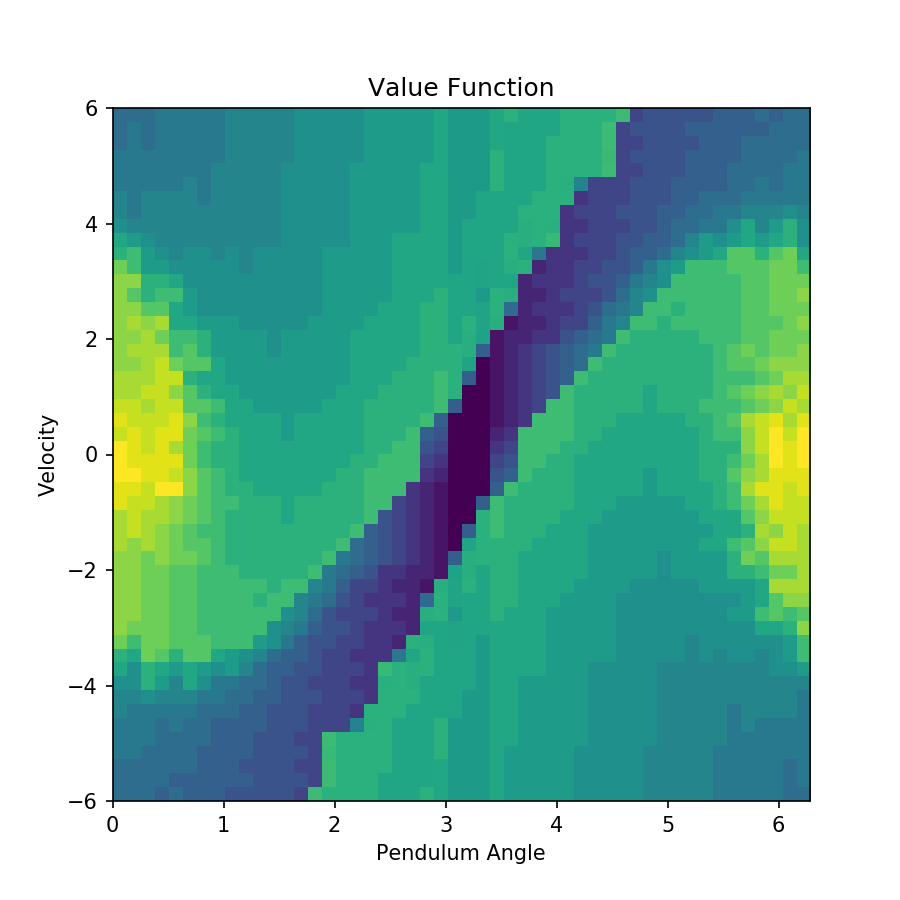

<IPython.core.display.Javascript object>


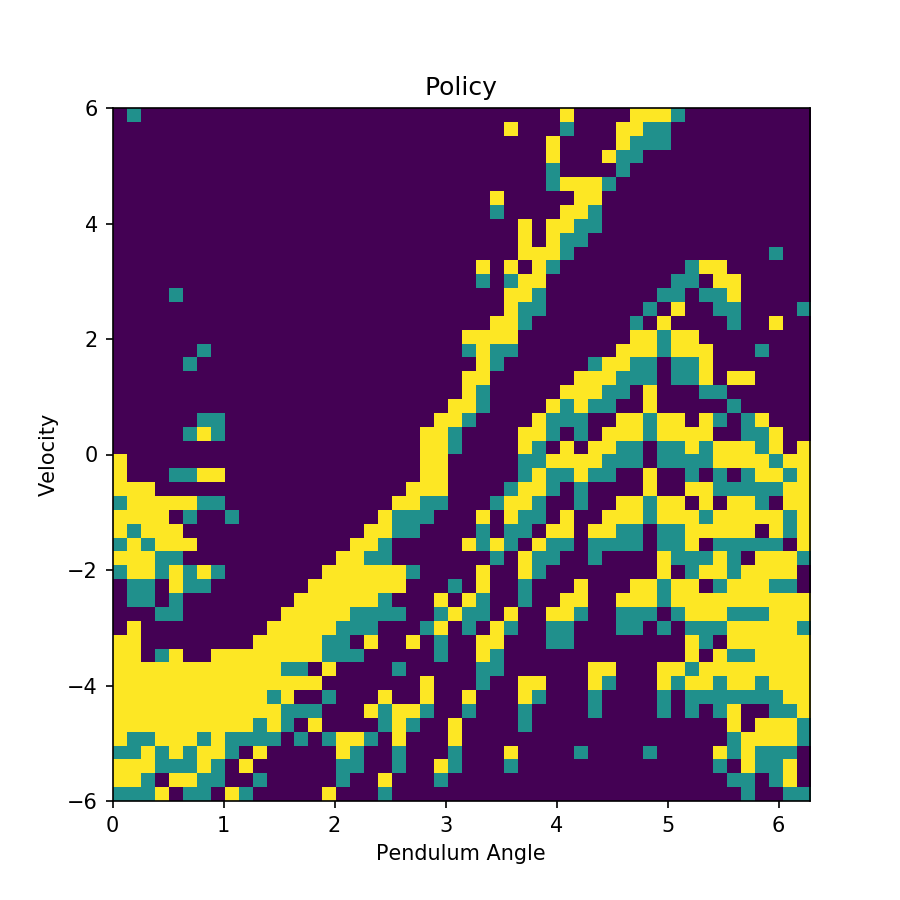

<IPython.core.display.Javascript object>


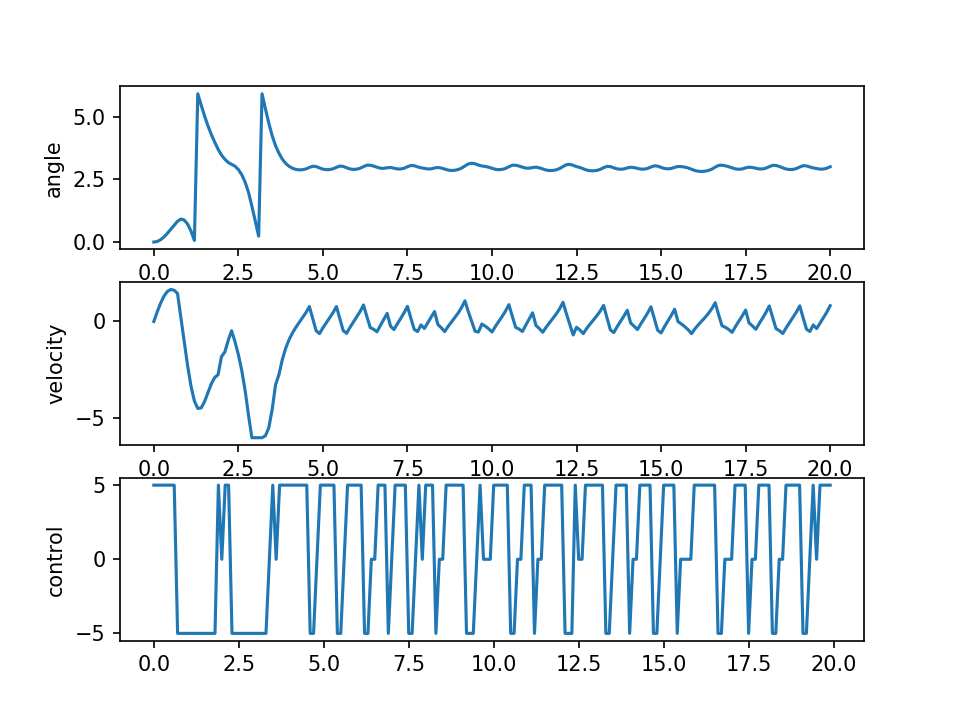

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAD4u21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0TZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZYZCdC/yYgAABXwAsgZkmelx
SROADzDHsnTdNPwqh0IYXPcgsx/VdOgPtpJk3xmz25oQD2NxIJATjjPFHtCPYSSyrz7P5apm+qGo
CaO0hQa9TgblAkEBRtsbJoJjDfyhjQSKoxTNex2bKxAqRTNoM297EWxml92F4SgqAa9lbwbZ8+3M
8l0TfdHNaygcBuoe/stRvUXLZinWJDX2fTyHC+vsg7SSDh9VCALo/f8LntmbRMOk0qgXCi/HjrLA
aDHF+z18yVLK2z74iGw43VhNdJn7sOk6H3E21bAuxha9GcFT2B/gDsnAFBY5gBiZPeVxVbYpe4QY
u/Qkmk29MQ1rmTd5w6tt8rxwNyDWYzoDXLAPOxYEu0cWoQcXPjpp4iBWBfo93KDgq6XQij4Oj1LG
DzySMr38uhgbYXdV91VBopGTufKSekk2ZkKOtbq4Kr/zM9vviogAubMfy1/YSD/ic+Z6ysWZsCH9
C/Zb2JGjR9bSRhckMQjaefOfq/lWNB0Xc02qNBl4/tmwJ+ebj1DFzGQstTU5DNYJEWPy2onLh1jJ
lWvdRIW7fr/mXI8quKp4zTyFY5rPKTKvy/lZWNlRzZxT/qYO8ABZXt/bpnl/VGU1VMyptPo0GoOL
ZkrOkkAvsLBGg3a94AsDuJU2SWT/5ITXHXD32bfb7xC9j5XGmQA4PGpknP4U2yda4nUJ2uVBRdAA
AAMAAX/AgZEz5dHIEl9RYEFsToTz/SHFFFy+MbpLCN7YlzYblDF6HaIZM0CYuK/XiiWJIeYSacek
CyFQZiK+RNwSsWscdLnUIq1NsO+XI9+1CaikhVxWmDZwuPALes/5GI22nhF+E+hbu56e732jJWYO
CfAv64wXnCLZN3LUphpVnqvFSNQ629fGSvhoCL1WFN4rzHYuTI/WQo/ZrR5g8olHkzhX9bfxu6vf
64LrSARhnCrhRQmF+EulC5Zjp1oMuZsySfx0Q4rEf7CEfWDOLjA8AjIXfjL9lEJkgbHEVyUHrjtU
OlFiEbs3geGT7xELIwaJxWN/CKKbJCmhOINodhwdYlxdZNftXIYqodTI3X10Yh4ynIkhEVJxo2qo
ppLqI9kXM0U+7zVUCKQ+JrltXRM1Q2YkJUkXPcvYHr//RdWDs7m06ApkBncN5LNZI2ibtqjLNJQe
1VG0sMXAK5p1W/+OPPHun/kEiCD+FEeq2fAePoS7T6yK2WMhiEJdwQlJojuxSX3aU0Er3XmIbDAi
wmRIMjfdIb90eQU0LeXai9wlCYYCJZn+xZD5vfaCavA81E+V2cNk7IwkTCmGCd0THH8DJqZh0uwQ
2jS+LovhSF0CbpcCYdtdaQyWFk+OHqiaKN/GASLaV0SkAc3xGzEfpbH/9zRxy+taxW7tIsMFuwzt
XS1C/hxVuEMyO+Ku+Ov1hoBdpA1eITR2kf2wf+F42xTFYJYvG1Vq891h0WjF6zxzzs9hhb8+sw7l
hcyBKQ0Yo4rNsu2hcFQ3RnU6CsPiO4UEY044fG/0eCdBv7ktqTAwASk0vS+deIcHND/F7CpnAjcm
1WEedHyeUaVSXBggSstauvu7wf5ivX/IqDj+iOWD8rjUCIucN6TjSCYGdrWVhelYMV08lxZrLait
SStxK/LXhapnfBImDg6ssL28dhtev3bnm9eKTs/tjUBFf3+ubaxzs1HcSIOWtiMH/CyTkWmX0Yt/
xYb/BFvpKG05mPMHrksiUvPmdGHkNEILqoTBLYO/fBCmvsyS1eS4BKke/Gfym84ZGO3jB10S5kkP
KophD++vcIQDmXv508To2DAwXHR/8+W5fzb3o71qI4IO8R8J33MBesUR5nureJLw+tn1E+DrYgvR
0aU5YBMe8rlHzuJHPlXJsKjrv6QiedxPIZiCfd8R36Ajl6qM+7LYFvP3X+fzYGv1M1oSRz5PRue4
Y45xACcG2bcQyKxQsdWIse2seXJxXB53+xcuWVHIIj0g8qN2cWsgJlQ4VwWYfqG8AmaIZ6+gxA5a
pBwUIPe6NgwopJIltflRSa4T6ke14z/89C6gtvEskn9OIA+O0Zdls3+xYc26Erh9spaJbf4X1TVe
6NzFsVmYoCmQI151pLF17NJ/Ov30hF/mRHzc9AzvYJPdTWT/2i/XJTHq0EXgcg5yUgRwezTli7uV
n4+//a4UqmNuJqVdRbhuHjzfCoKYbN2+6IV6Bj70FnNjcRo2AUnDdaN4EvO3QdSI8nTz/l9Uo0q7
ePqnqDLM+j+QDu1xjMUgMcA5DIwevrEt+Uqqc1gdsTvWm3l4vlAO8NbeHz/dlbjkXYTveqksbkAs
Es55lZ6PjFaUaL3dq6AU3z2NUDy0clcIqbf7AAaBnKJ48lJb1Eoub0LFks1cE0ovi1eoAAADAAAD
AAAmKN7tpf/GB30NYGeQhVaJbIKoiNawcGeC+lSh5EGrOMwdEZ6e/i/Xq2qhcKp58VPHGUjQVNt7
MWFCOlc1evdRkjti5t6yJNV5L+dIeQ5bRWwHX2m9a9Kc31RAf4xfACDmWSgdIoaDCTEZTZm34MGo
/mg1qVbem+2jx6P7SzZEf/5ENWu4AQ49qDVYwaTqIaLY7sVluekCMso0XZxqoZeSfYcXnLyd+lNq
K6O2bRSgP07tPNBq7rIYJm2YF/O9JPyZb4Ee8xrmv59nF07lPWJLCliKBmL7klxH2PflC/ZuSBFc
zi2wOeGP2jzRTtIisdMWOgqmS+nbHjcBQODf7IdwiqAXHpR3nhr5QDuyUlpv3CUSXu2+QrH6o/T+
56zS3/YZ2k9TkMxrOUD/7sGt8wrMzEwlhXAJ3M7IfuhChpYom5b/95N4na0tNYcBaMEuN+cckOLf
53jGGJ80W4bUwiAUXaYHW

In [10]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration(pendulum, cost1)

# we run the iterations (with maximum number 2000).
value_iteration.iterate(2000)

# we plot the results
plot_results(pendulum, value_iteration.value_function, value_iteration.policy, animate=True)

# 5. use 5 actions

In [11]:
# we instantiate a pendulum with discretization 50x50 for angle q and velocity v and 3 actions
pendulum = DiscretePendulum(nq=50, nv=50, nu=5)

CONVERGED after iteration 1056


<IPython.core.display.Javascript object>


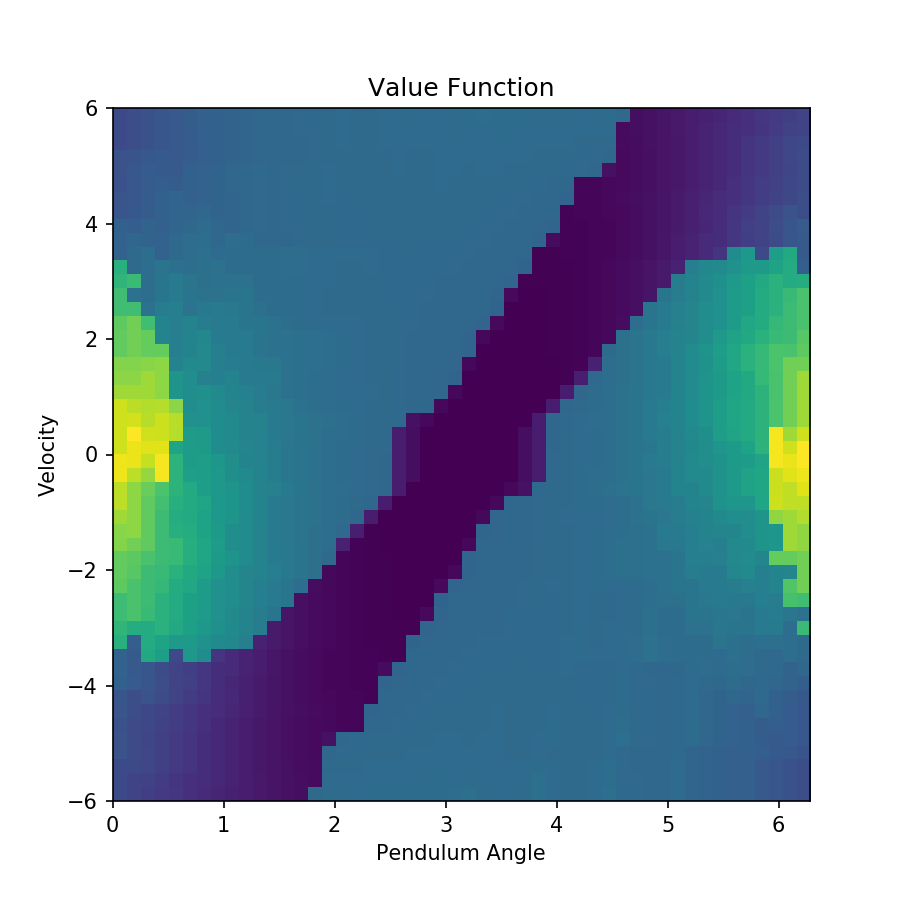

<IPython.core.display.Javascript object>


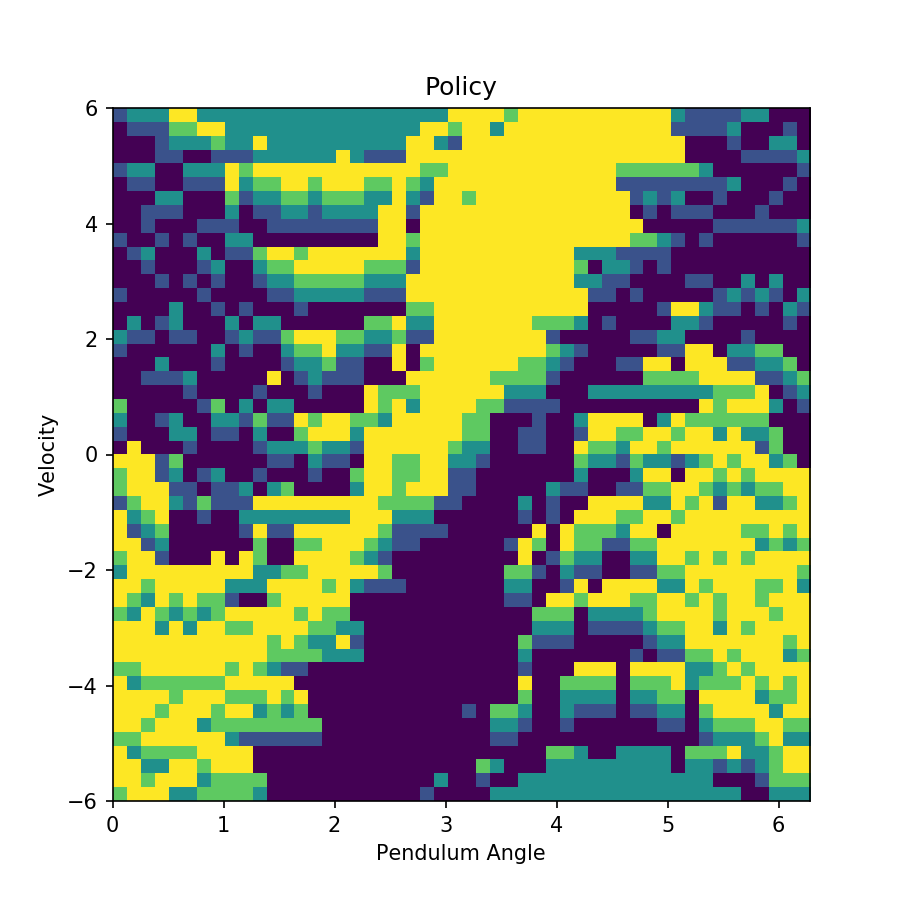

<IPython.core.display.Javascript object>


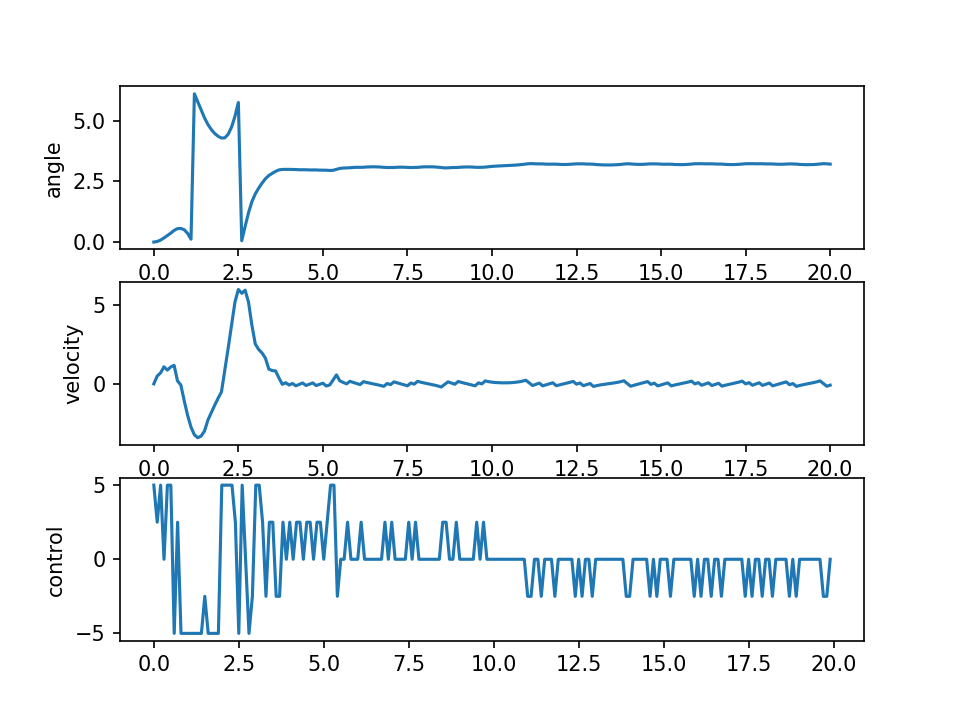

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACv8m1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0WZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZYZCdC/yYgAABXwAsgZkmelx
SROADzDHsnTdNPwqh0IYXPcgsx/VdOgPtpJk3xmz25oQD2NxIJATjjPFHtCPYSSyrz7P5apm+qGo
CaO0hQa9TgblAkEBRtsbJoJjDfyhjQSKoxTNex2bKxAqRTNoM297EWxml92F4SgqAa9lbwbZ8+3M
8l0TfdHNaygcBuoe/stRvUXLZinWJDX2fTyHC+vsg7SSDh9VCALo/f8LntmbRMOk0qgXCi/HjrLA
aDHF+z18yVLK2z74iGw43VhNdJn7sOk6H3E21bAuxha9GcFT2B/gDsnAFBY5gBiZPeVxVbYpe4QY
u/Qkmk29MQ1rmTd5w6tt8rxwNyDWYzoDXLAPOxYEu0cWoQcXPjpp4iBWBfo93KDgq6XQij4Oj1LG
DzySMr38uhgbYXdV91VBopGTufKSekk2ZkKOtbq4Kr/zM9vviogAubMfy1/YSD/ic+Z6ysW11mqE
aw28fkE07LoVANnt98/WFOh2kP4qKS2EOW2R/aA3Z7G+ebWAmpyGawSKOP74xuxvFb5q1HlG8DH3
O6BFg3INvuHOb9LHOidxhtyJ3CtFzNDKZ6xn6mDvAAWWi6X5dO/wM3+9oH84RnZyXvVBZTxz37Y9
CWBZs8SWxmeLauVtCDCWXGmfqsrX46rQWMB4u9lYrAKwMZuizVue6UnRPHemBWdGnkbqAAADACD0
ANcQ40/Hq0+C/IVB7E6E8/0hxRRcvjG6SzMaY96vEYW1Xq25smcnLCILhZkmJIeYSAGekCyFQZjX
eMIfOxfYRRQ2+M3jcOu+XI9+1Cai1TA2ZnqILS7wLes/5PvPhzldRLw6Mi6AF/02jJWYOCfAv64s
q38qd/OkSMhM82heKkah1t6+MlfPfYXqsKbxXmMBfmR+shR+zWjzB7+tfJnCv62/jd1fmY1Oq8bJ
7OFXCihML8JdKGSzHTrQZczZkk/johxYB/8xdIU4DKDA8SZO/kX0YZEeZbYD6GtxFff4iURRWs54
Dv+ydX0vtnn2lJbKBotiDfFc/5//jho03ItE+ZGRgm2gwZG57kWhB/1PVxb4iL9/RY37GzfaC07N
m4+I0Wwo+o3lTrzEyGwdAixod0sZ+ZCJRYd/a1HS2eCZoNViqys7+BKogPiakhwB8zEdv/q6BRwF
Sv8v8IgWgxCJp9CO2AvUO49PVDFT2xQkaULAUYOTk7p5+4FrTDsJRxMk6yay7rB2FbDZmqP4E3Ad
5bgcwh3XdE5dLRkyQbFUSW4xYnG6BMd7CFkEWDYLnI0CIFrEDGc4kthehA9+6mYdLsENo0vh4GYU
YrI2rRiW/zZtVOag++4kiSXolLVjwX2Rt5SfG6Iojsd4FgL+PXxf9Ng28N3U63uHuwoYpZet1i43
CGZN9hrvjnIA0AXWP6RtR2b+6lXLEYf+F43F02poX1MvQg/wU2TXr2lkRBXjYaaUyz02+rT7wEhJ
9vU++daGMWm+jGNUABpQhAspZS8Wa9BQqu++Hr2VwAKOAfjNkACuJCqMRZ4qpFgRUA2fOu+igmv6
hAiPgRTxwb/jmT12oRHQ/gFzZbqKNbhbb4OpF/tQOEPErRYLO483o1hqkHmpNm5ZSmCb1pIVkIsU
3te+/wdpLLgeM7oPJQgnHtMizr0MLhr6djFbFbd7tSlQUZ9vpUNRUFPmu3Uykwbx8/3nVHN4GmEz
eERBnhzPmtxxWnVC0W2f5BZYwvMNP+uoE6EkXsxtSUIbiAE+MYfitVr7r+tzl0J0ijtByvZxTGHU
/VztAFGopzfh/Wmq7sPst/nR/8+W5fze0kpeNVVXSs3Iu3yLxxZhgvU9gZe2yz1/tPNe9pRDZt+M
IRTItO5k9qW/YjhtMuYiAORbeNb4zYSyfqLRJOOZapZg7yGNEhesVluv1zpu5WlpBdNPRueZGt4m
DwINLzQC+E55wuh5NxrM8HW1BMK/H601pxF0CYQ0Xb5zWWPXgmM5X7MMaQIOCqBw4YMbdVTYa2pj
JICiifPqrFH03QNdGm4zmkjuA7delVqyOVfZ+R/oKHLWULy3c6WCiJopzrkpJJeRI+0Pe50uDwHz
pOHOG7Nb6Ni5dhnEFtK9NxWkf2wF5iRhozTUmJe5tQyExl/RQC6YC7Bjggj1YqG6ql08bLKzPRQn
CyPT/4MGvLZbDFzyvCUNYXhEwBbCKqQtdbBEf68y3D0c/OvzCnNaKwiTmPEenrhBewI2mRXx1Z/L
kkt73ifv4pxSbHPoGJCeqz8ZzDfcudwvXxTW8oiQUDIsTgv1Y/qMtsVJKXjmvt++Ise1TFAP8Lyr
zwrEajTqUby6Jl68AmxXYWTFMqHQOWItT+3IABxqbQXHkFpeh5V7m4ymW9JzI9kt4AABAAADAAAH
oG1cisQ0f3VdqTgHujVBmW4nbpoYjQ4Z8r0SUtVZmdtqOJhnOgIh458iJfOKhlxibtepxRnFCzT1
LWJfUZW0HEpOpangclIHz/Yvedvl/sa+9+/RXDbuU08aN+zJNcR2pm0+s6TCGTaOBVP/wIWf2aiy
Bi9z2FuYNTnWQXXUOzGHU6npZCWHxSQd3uE+ogMz9KF12Ex0gxfaVRPA+MCUe97vVXn+GwniuTtb
i8pKEBtIVUCk1GBTW5BB0ZZ0z0MaERzXd7kq9x4dX9yee5IQIJKqYOqY7WOYh4jb5lCllm3Xf1Kx
2dw8YZ4/upEBrVvjOu8uWd4ZBfAf9mOwuHQzh7T8phku3WIQIa5X+XdUrTEH4gLMpCvDgv3Q/QEf
FWEGJmus//EsVmpLWjkhFskN37ETqi/4zSRCuBEQFsodAmiBUqRrhnaYKczz158o3XBshfBH4ZkB
VmT8+uY8XXluG1MIgFF2m

In [12]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration(pendulum, cost)

# we run the iterations (with maximum number 2000).
value_iteration.iterate(2000)

# we plot the results
plot_results(pendulum, value_iteration.value_function, value_iteration.policy, animate=True)

## Exercise 2
1. Implement the Policy Iteration algorithm 
(Hint: for each policy evaluation step, you may use the previous policy eavluation result as an initial start)
2. Compare the policies found using value and policy iteration - are they the same?
3. Which algorithm seem to be more efficient? Why?

In [13]:
class PolicyIteration:
    """
    Skeleton class to help implement policy iteration (you may use it or write your own solution)
    """
    def __init__(self, model, cost, discount_factor=0.99):
        """
        receives as input a pendulum and cost function and potentially a discount factor
        """
        # we create a table for the value and policy functions
        self.value_function = np.zeros([model.num_states])
        self.policy = np.zeros([model.num_states])
        # we also store the index associated to the policy
        self.policy_index = np.zeros([model.num_states], dtype=np.int32)
        
        self.model = model
        self.cost = cost
        self.gamma = discount_factor
            
    def iterate(self, num_iter=1):
        """
        the main iteration of policy iteration
        num_iter: maximum number of iterations to be performed. 
        
        If after an iteration the policy does not change (e.g. less thant 10e-5) 
        the function should return and print success
        """
        for i in range(num_iter):
            #policy evaluation
            self.policy_evaluation()
            #policy update
            if not self.policy_update():
                print('CONVERGED after iteration ' + str(i))
                break
            
    def policy_update(self):
        """
        TO BE COMPLETED
        Policy update function 
        it should return True if the policy was changed and False otherwise
        """
        change = 0
        for i in range(self.model.num_states):
            # store the value function under all possible control
            r = np.zeros([self.model.nu])
            for j in range(self.model.nu):
                next_index = self.model.next_state_index[i,j]
                r[j] = self.value_function[next_index]
            if self.policy_index[i] != np.argmin(r):
                change = change+1
                self.policy_index[i] = np.argmin(r)
                self.policy[i] = self.model.u[np.argmin(r)]
        if change<5:
            return False
        else:
            return True
            
    def policy_evaluation(self, num_iter=10000):
        """
        TO BE COMPLETED
        Policy evaluation function 
        """             
        self.value_function = np.zeros([self.model.num_states])
        for i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(self.model.num_states):
                # the current state and control
                x = self.model.get_states(j)
                l = self.policy_index[j]
                u = self.model.u[l]
                # the index for the next state
                next_index = self.model.next_state_index[j,l]
                # compute the cost
                J_new[j] = self.cost(x,u) + self.gamma*self.value_function[next_index]
#                 #here we also store the policy (so we have it for later)
#                 self.policy[j] = self.model.u[]
                
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-5).all():
#                 print("after iteration " + str(i))
                break
            else:
                self.value_function = J_new.copy()

<IPython.core.display.Javascript object>


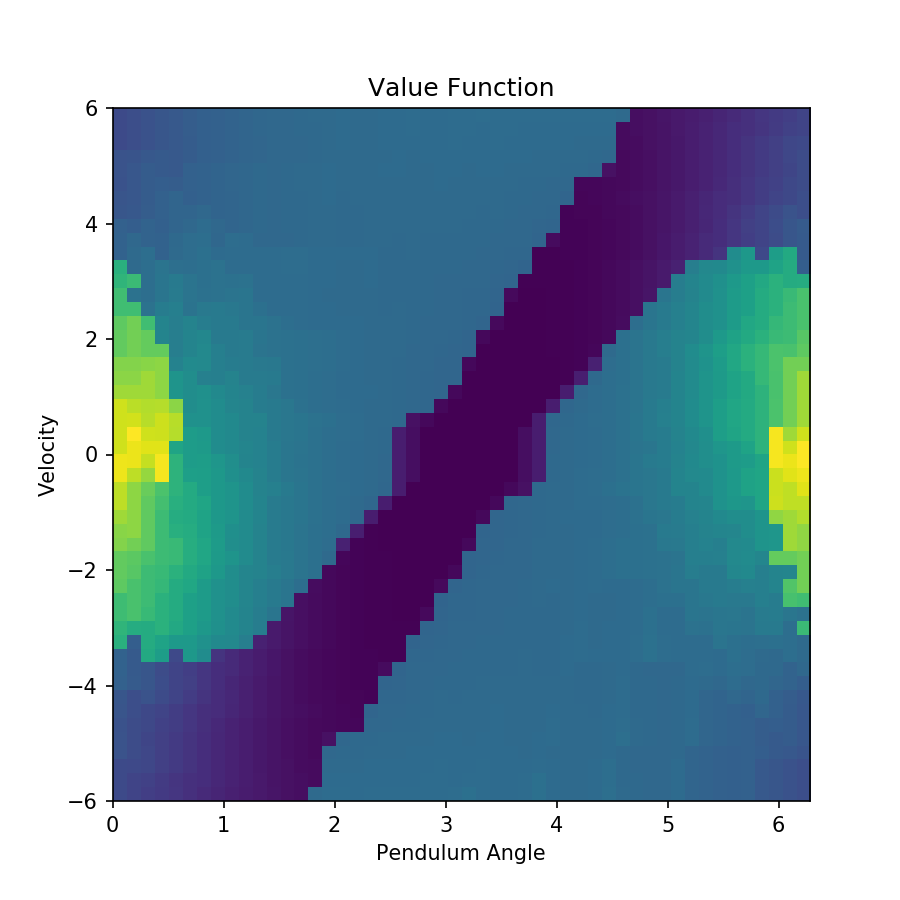

<IPython.core.display.Javascript object>


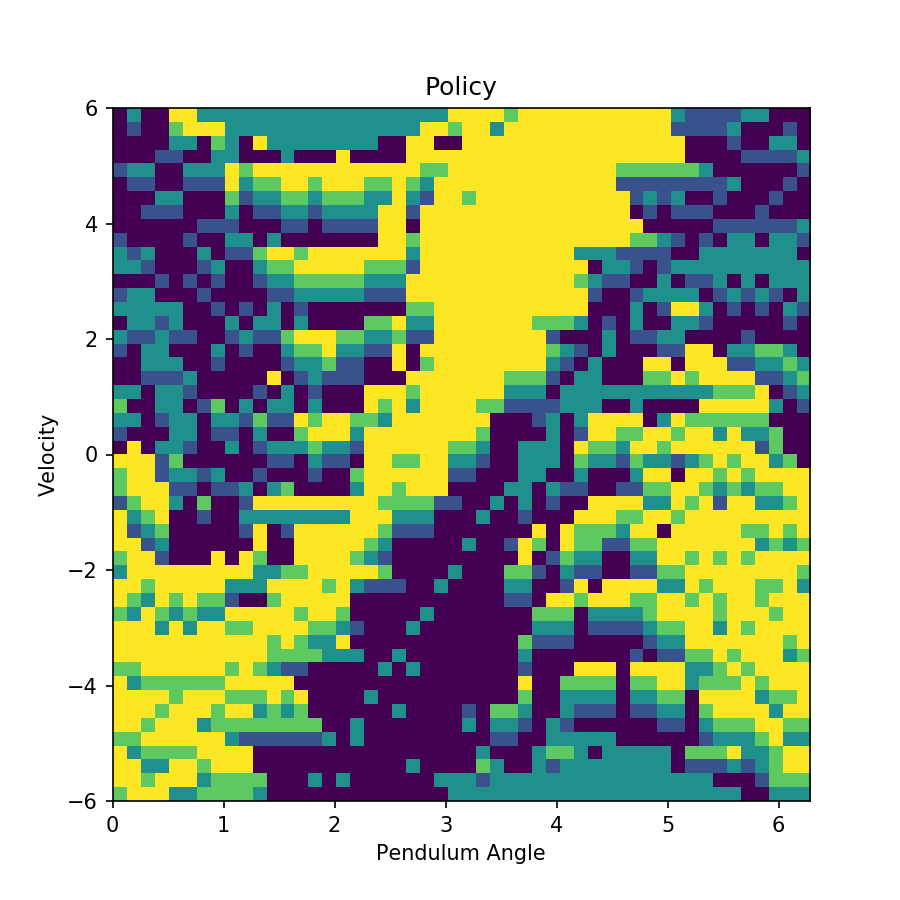

<IPython.core.display.Javascript object>


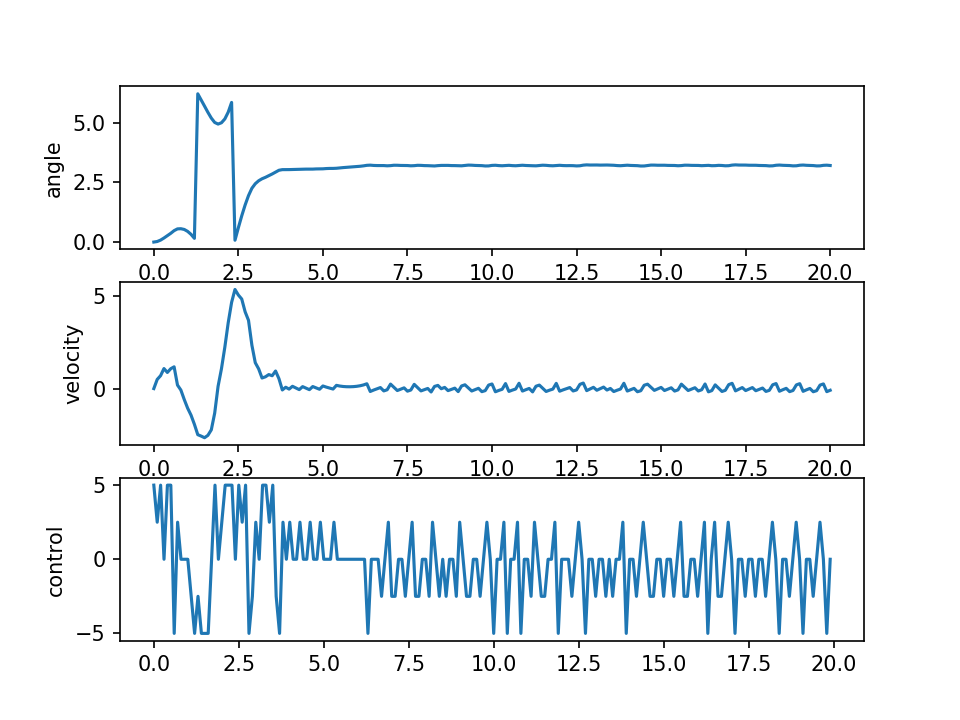

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACmGG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0VZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZYZCdC/yYgAABXwAsgZkmelx
SROADzDHsnTdNPwqh0IYXPcgsx/VdOgPtpJk3xmz25oQD2NxIJATjjPFHtCPYSSyrz7P5apm+qGo
CaO0hQa9TgblAkEBRtsbJoJjDfyhjQSKoxTNex2bKxAqRTNoM297EWxml92F4SgqAa9lbwbZ8+3M
8l0TfdHNaygcBuoe/stRvUXLZinWJDX2fTyHC+vsg7SSDh9VCALo/f8LntmbRMOk0qgXCi/HjrLA
aDHF+z18yVLK2z74iGw43VhNdJn7sOk6H3E21bAuxha9GcFT2B/gDsnAFBY5gBiZPeVxVbYpe4QY
u/Qkmk29MQ1rmTd5w6tt8rxwNyDWYzoDXLAPOxYEu0cWoQcXPjpp4iBWBfo93KDgq6XQij4Oj1LG
DzySMr38uhgbYXdV91VBopGTufKSekk2ZkKOtbq4Kr/zM9vviogAubMfy1/YSD/ic+Z6ysW11mqE
aw28fkE07LoVANnt98/WFOh2kP4qKS2EOW2R/aA3Z7G+ebWAmpyGawSKOP74xuxvFb5q1HlG8DH3
O6BFg3INvuHOb9LHOidxhtyJ3CtFzNDKZ6xn6mDvAAWWi6X5dO/wM3+9oH84RnZyXvVBZTxz37Y9
CWBZs8SWxmeLauVtCDCWXGmfqsrX46rQWMB4u9lYrAKwMZuizVue6UnRPHemBWdGnkbqAAADACD0
ANcQ40/Hq0+C/IVB7E6E8/0hxRRcvjG6SzMaY96vEYW1Xq25smcnLCILhZkmJIeYSAGekCyFQZjX
eMIfOxfYRRQ2+M3jcOu+XI9+1Cai1TA2ZnqILS7wLes/5PvPhzldRLw6Mi6AF/02jJWYOCfAv64s
q38qd/OkSMhM82heKkah1t6+MlfPfYXqsKbxXmMBfmR+shR+zWjzB7+tfJnCv62/jd1fmY1Oq8bJ
7OFXCihML8JdKGSzHTrQZczZkk/johxYB/8xdIU4DKDA8SZO/kX0YZEeZbYD6GtxFff4iURRWs54
Dv+ydX0vtnn2lJbKBotiDfFc/5//jho03ItE+ZGRgm2gwZG57kWhB/1PVxb4iL9/RY37GzfaC07N
m4+I0Wwo+qnYN2AEMhsRKuEWNDuljPzIRKLDv7Wo6WzwTNAaWKrH7rgSqID4mpIcAUMn2Z/0GLnC
hCKPKsCW8hKoN3NWigTWL2PLGIYVQoKknF+1/gj/1N2RlTQd2AsUIoEnstHZHDt4wiDxYMchpTbo
B+R0Q2Ye7+B645LqC2qrEh1+XwWT32y0J8shczAywcomFMME7omOM5s9thfVa7ml1NG+FrMW7UE3
S4Ew7a60zX+zOz7KJJeiUtWPBfWx3lJ8boiiOx3gWAv49fEMk2ZqY9LkAfuImEmmPz+Bg+T38jzf
xWRGu+T9aZVIAPMr7rnueIxKYf+F43MOrb2jXJ9gXRKtta8zHNB6ovaf93F6X7mk7JndT6gvWxzZ
EhFZhN0N4UqeRDHtH6mWj88EllYujH+i45hEEG2uM5MWAAsKKbaHPY3koF9kk3JTmrmesbM7qk3L
vgSc7oghZgcu0dtLoRw+iRfdN+lSHh6r2uJEdZQQzYuk5Ff4ouYSRFOp5CEECS41WfOx+qOw21z7
t7v7QhkCPs6i8e+NQALf8BXgpaConvcDI/C7xKoFmtJUY+Rk0pz+Bu79SkE9tU8pLPEfqIGHlbk3
UhRWg7Yfu0r9oCJjI1r+tNSIfbARW917PvQjBTrrZiX/FwGvNk7OujgOJjy/8sRza9gTJ3RM8ICZ
GqE+TlKDZFXeMCOOHNAdrxucqoP7SKFFTD/2qNxT77c6ZKsVwPrbP5Hb3gEQB9r+MrEd3VnteXLO
ef577LsEyc2OOsdR3rUt+xHDaZb4m6EFt41vjNhLKAKDUSJl3uN1+LK/ZR2OaKYYe1W7uVaEkc+T
0bngaL6Oy4EGl5Ol7fbWxzQkF5uq4YgosizjSecI22i63+dEXb5zWWPXgl9vH13i+gnm/ebhww88
5aGw1tTGSQFFFc89f0q6xRl3HiR7n0O4Dt16VWrI1WeVTI+u+9nNrnLdzpYKIminQFjJJLyJH2h8
nr+2eA+dJw5w3ZrfVe6TX3u4vSaIoL2u8PBHzEjDRmmpMS9QnOsfSp9Uvz4RuUROaQR6scHYa3Rt
HqKShT6DTIGp//Eg3+szuW2dJjCDE1jVw7lUZAha62CTt1KxeJy7tEnOCf/6qHlIcaxssFJaEXyX
VDnxNnY8L4q3bJLDlx3KAxFHAxMx+JAMgex+/t5b/M+Ri/UQpTl2IEVP+gGXV9GZF7E6CENt5w25
0JAVXqvQTg7T6MNhWQPE8hQEsZa429vLltOVv4aKxoAAMqD8XVCeH+Q90SNdvGTmqIKdcB9WKf5h
UcUspjGIM9JxfryPDSzPB9VaNiJagNvEY/9NtsuhlAL+sfxQG4MWkCNWlQgwnLHcioA6nezFhQjp
XNXv1/Vm55LCZn/Px553t/nFPo1aFrNjUU08aOEC+Xgj6szafWdJhDJtGZW7z+/S+SIV7Y55EH+e
tALxc8yqaHMvtuBmSNDlROhNY4PkWnOSvLM/ShddhMdIMX2lx827tlSG3e71V5/hsJ4rk7jLMH6d
2nmg1d1kMEn3kuPtOydM9DYsZd13e5KvmV5tgXHnuSECCQWiDqmO1jmIeI29NpjAdnun+pWOzuHj
DPeLY4tNoEV8oR0VYRrHqfH/68S02FeBetrVr9xbttU7D5hR2+MAHukLzVqcGnhHLfiq2sVpph+z
Xa4f/Imy/Yawm82wgJMjeJoNNIsmf6awVwIef1/HAmiCDbznokgjJ/MUvRDn957dvhoYAgtoSHMj
04YwxPmi3DamEQCi7TA61

In [14]:
# we instanciate a value iteration object for a pendulum model and a cost function
policy_iteration = PolicyIteration(pendulum, cost)

# we run the iterations (with maximum number 2000).
policy_iteration.iterate(20)

# we plot the results
plot_results(pendulum, policy_iteration.value_function, policy_iteration.policy, animate=True)

The following two exercises are Bonus. Answering these questions will give additional points towards the final grade but it is not necessary to answer them to get the maximum grade.

## Exercise 3 [Bonus]
1. Implement Q-learning with a table (use episodes of at least 10 seconds and an epsilon greedy policy with $\epsilon=0.1$).
2. How many iterations does it take for the algorithm to learn how to invert the pendulum?
3. How can you compute the optimal policy from the Q function? And the optimal value function?
4. Plot the learned policy and associated value function and also show these functions at different stages of learning.
5. How is learning affected when changing $\epsilon$ and the learning rate?

In [15]:
class QLearningTable:
    """
    Skeleton class to help implement Q learning with a table (you may use it or write your own solution)
    """
    def __init__(self, model, cost, discount_factor=0.99, learning_rate=0.1, epsilon_greedy=0.1):
        # we create tables to store value and policy functions
        self.value_function = np.zeros([model.num_states])
        self.policy = np.zeros([model.num_states])
        
        # we create the Q table
        self.q_function = np.zeros([model.num_states, model.nu])
        
        self.model = model
        self.cost = cost
        
        # other parameters
        self.epsilon = epsilon_greedy
        self.gamma = discount_factor
        self.alpha = learning_rate
            
    def iterate(self, num_iter=1):
        """
        TO BE COMPLETED
        """
        q_Last=np.zeros([self.model.num_states, self.model.nu])
        for i in range(num_iter):# 
            # choose initial state x0
            x_0 = np.array([0,0])
            x_index = self.model.get_index(x_0)#random.randint(0, self.model.num_states-1)
            for j in range(2000):
                # choose an action using E-greedy policy
                if random.uniform(0, 1)>self.epsilon :
                    u_index = np.argmin(self.q_function[x_index,:])
                else:
                    u_index = random.randint(0,self.model.nu-1)
                # observe x_t+1
                next_index = self.model.next_state_index[x_index,u_index]
                # compute g(x_t,u(x_t))
                x=self.model.get_states(x_index)
                u=self.model.u[u_index]
                # compute TDerror
                TDerror=self.cost(x, u)+self.gamma*min(self.q_function[next_index,:])-self.q_function[x_index, u_index]
                self.q_function[x_index, u_index]=self.q_function[x_index, u_index]+self.alpha*TDerror
                x_index=next_index
                
            # we update the current Q function if there is any change otherwise we are done
            if ((q_Last-self.q_function)**2 < 10e-5).all() :
                break
            else:
                q_Last = self.q_function.copy()
        for k in range(self.model.num_states):
            self.policy[k]=self.model.u[np.argmin(self.q_function[k,:])]
            self.value_function[k]=min(self.q_function[k, :])

<IPython.core.display.Javascript object>


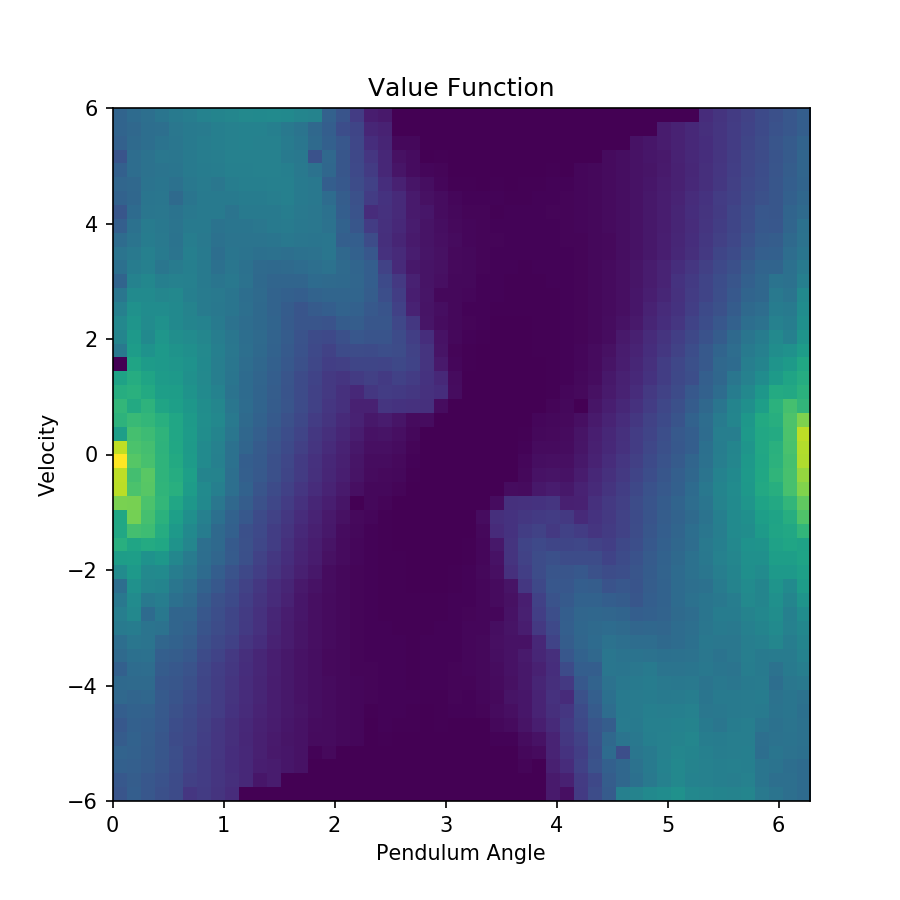

<IPython.core.display.Javascript object>


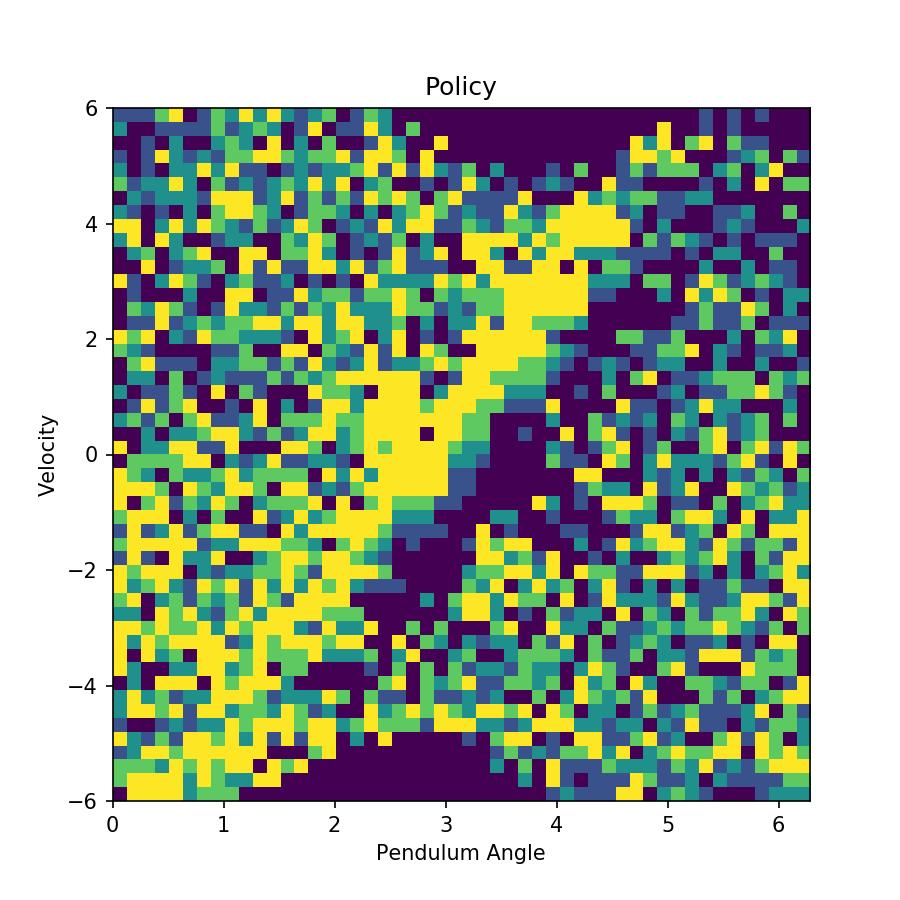

<IPython.core.display.Javascript object>


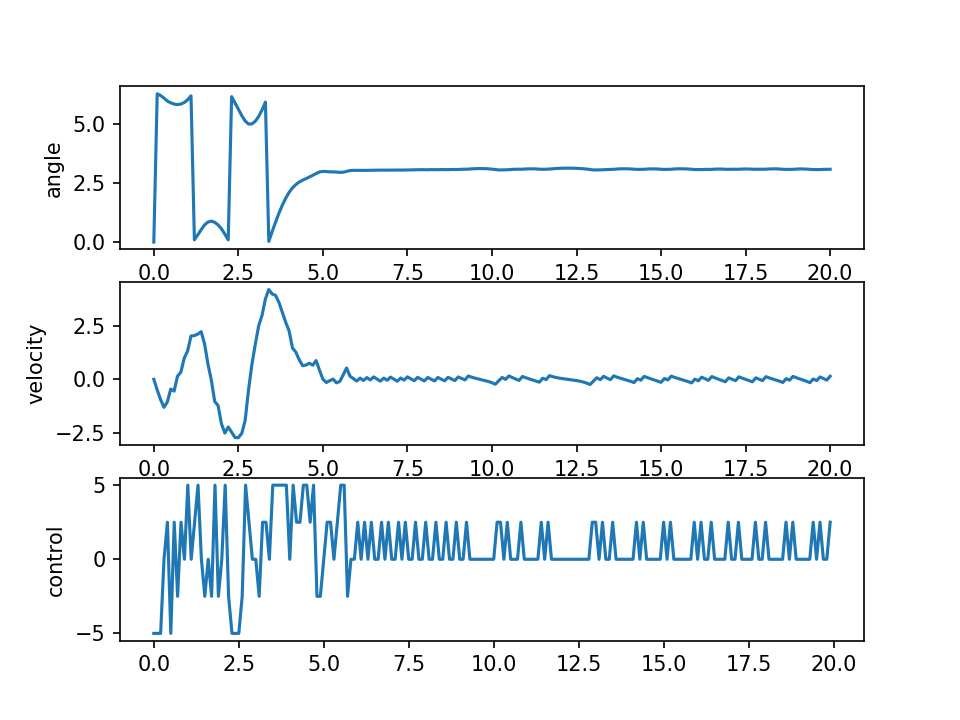

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAC63m1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0LZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZYZCdC/yYgAABXwAsgZkmelx
SROADzDHsnTdNPwqh0IYXPcgsx/VdOgPtpJk3xmz25oQD2NxIJATjjPFHtCPYSSyrz7P5apm+qGo
CaO0hQa9TgblAkEBRtsbJoJjDfyhjQSKoxTNex2bKxAqRTNoM297EWxml92F4SgqAa9lbwbZ8+3M
8l0TfdHNaygcBuoe/stRvUXLZinWJDX2fTyHC+vsg7SSDh9VCALo/f8LntmbRMOk0qgXCi/HjrLA
aDHF+z18yVLK2z74iGw43VhNdJn7sOk6H3E21bAuxha9GcFT2B/gDsnAFBY5gBiZPeVxVbYpe4QY
u/Qkmk29MQ1rmTd5w6tt8rxwNyDWYzoDXLAPOxYEu0cWoQcXPjpp4iBWBfo93KDgq6XQij4Oj1LG
DzySMr38uhgbYXdV91VBopGTufKSekk2ZkKOtbq4Kr/zM9vviogAubMfy1/YSD/ic+Z6ysW11mqE
aw28fkE07LoVANnt98/WFOh2kP4qKS2EOW2R/aA3Z7G+ebWAmpyGawSKOP74xuxvFb5q1HlG8DH3
O6BFg3INvuHOb9LHOidxhtyJ3CtFzNDKZ6xn6mDvAAWWi6X5dO/wM3+9oH84RnZyXvVBZTxz37Y9
CWBZs8SWxmeLauVtCDCWXGmfqsrX46rQWMB4u9lYrAKwMZuizVue6UnRPHemBWdGnkbqAAADACD0
ANcQ40/Hq0+C/IVB7E6E8/0hxRRcvjG6SzMaY96vEYW1Xq25smcnLCILhZkmJIeYSAGekCyFQZjX
eMIfOxfYRRQ2+M3jcOu+XI9+1Cai1TA2ZnqILS7wLes/5PvPhzldRLw6Mi6AF/02jJWYOCfAv64s
q38qd/OkSMhM82heKkah1t6+MlfPfYXqsKbxXmMBfmR+shR+zWjzB7+tfJnCv62/jd1fmY1Oq8bJ
7OFXCihML8JdKGSzHTrQZczZkk/johxYB/8xdIU4DKDA8SZO/kX0YZEeZbYD6GtxFff4iURRWs54
Dv+ydX0vtnn2lJbKBotiDfFc/5//jho03ItE+ZGRgm2gwZG57kWhB/1PVxb4iL9/RY37GzfaC07N
m4+I0Wwo+o3lTrzEyGwdAixod0sZ+ZCJRYd/a1HS2eCZoNViqys7+BKogPiakhwB8zEdv/q6BRwF
Sv8v8IgWgxCJp9CO2AvUO49PVDFT2xQkaULAUYOTk7p5+4FrTDsJRxMk6yay7rB2FbDZmqP4E3Ad
5bgcwh3XdE5dLRkyQbFUSW4xYnG6BMd7CFkEWDYLnI0CIFrEDGc4kthehA9+6mYdLsENo0vh4GYU
YrI2rRiW/zZtVOag++4kiSXolLVjwX2Rt5SfG6Iojsd4FgL+PXxf9Ng28N3U63uHBUDeEH8DB8nv
5Hm/hnAs0R0zNMNR1rdZtUCZlBWCMP/C8bRGPUgZImTtu8rk10wjdUbbIXWA+7h835zYSfedYY5s
jWYTdDeFKnkMKnQ5yoJZPBJZWLox/ouOYQRkgu/w7J0ANdOJO4M4vTXY7KSbkpzV0b1r+oQIkpv3
BFUzFkn1M9aGemGg/0rWijW4W2+HE7cZRioBAHejRIfIN/VhqkHmpNm5ZSmCb6CQ9ntZ2GPL/l7P
ZFHyt2UkHemk0MmC65dGGQ94Kidik7P7Y1ASZ1cbwNrPh/XFgxZo0vtL2hU/+XelnwtXelv4BQZD
htmgD9xQ5vTtR2gA3m7/UN4stv9Vg0iJXr1lzWFye4v8+hEjapwuRsvy7O9a05ESry0YSM3hsdti
yXm9zyNLDcG60Mix4vu7/o73W2bgCdSXJ1aGukSBrWKCHTh0//aB+lvI/ZvScreRbp9tNqCu9VIH
3H5qC5dOGFZeELMfHiQMX0upXazMtqJ1PnlWh9MYF5cAsJ9NO12OB/O0iVpaQXTT0bnt1KP9Xh6c
wjT5NgO+YxVg80HhlKmOs7fNn+LwnXDKgDaPuVG7OLWQEy3iNJCeP6hvAJmiEFYrUf6bzJiW1MFh
hZxp74Sp5M3WEkQt4m7dNirbb8BSv8KWST+mZw35VMuy2b/YsGYQ8ZD+PKvC4v+i5T3PGlTgL851
YasYX1edaSxdezHfAyothF/mRHzc8I0Mle16lK4c+LBXJTHq0EXgMsXlcvscrsAjeg2v0aLf+Tm2
osG4hrLpmdxr6/N8KRQ0KUlBXsHgGt3kH0rOy5O+BSPS5Mj/UktZNg03mYnZwfJRFtWZ9tSjalxR
0/61BbpkHVGk7NYGprYO7G6w+GiLNO0oFDAKAit8qhjraXrNl5CfHtZTI/sbTo0BE5CNMKS2ZVWm
LhR2v5f9OATBEAAAIsrD+HsRydn9iPtvkq7C86uyFokeoUmhn58RKUVM1xsS/z78j4cMJPboTrlj
FzX3lYkfHCyq8Xktv6MWKP/pzKfkc/j95AH9KkFyVdZaQLaaMBSZzPQIYInUujZmX/8YrODur2tW
279hQx/KtXz4G/ZOd1kVr5V0KlnfGYvvPyHE+JWZ4AQcyyUD6FiviuqpUuP7lTpeNjPHPBvdNOBQ
WN6ZcXYaZwRMaQW3/P5kAnN33uxWW56QIyyjRdnKbHsm3hoJO8vJ36U2oro7R5KUB+ndp5oNXdZD
BM5YByJBlnTPQxo79efZXpbpJI2TFNhtGK0s7Rg6mNeZscxDxG3qOudOFbHnLjivN+SdBHY6NgFy
g54TCRUyYPk0Q4eu/8iKkxWRkVp1dRrRvpjMaNeE674wAe7b5Dt0hmNmLxabSYGxNMVichmNZy2H
/m35TAMGJU/co0jPc1ALC4hRHt+TNsKCyoU4PCq/3ooZSWgj1rZsBsLJnblz5t5ZTDGGJjOYoasw
l6owexDzo4ITcJBA6oR1D

In [16]:
# we instanciate a Q learning object for a pendulum model and a cost function
Q_Learning = QLearningTable(pendulum,cost)

# we run the iterations (with maximum number 2000).
Q_Learning.iterate(2000)

# we plot the results
plot_results(pendulum, Q_Learning.value_function, Q_Learning.policy, animate=True)

# if change the $\epsilon$ and the learning rate

<IPython.core.display.Javascript object>


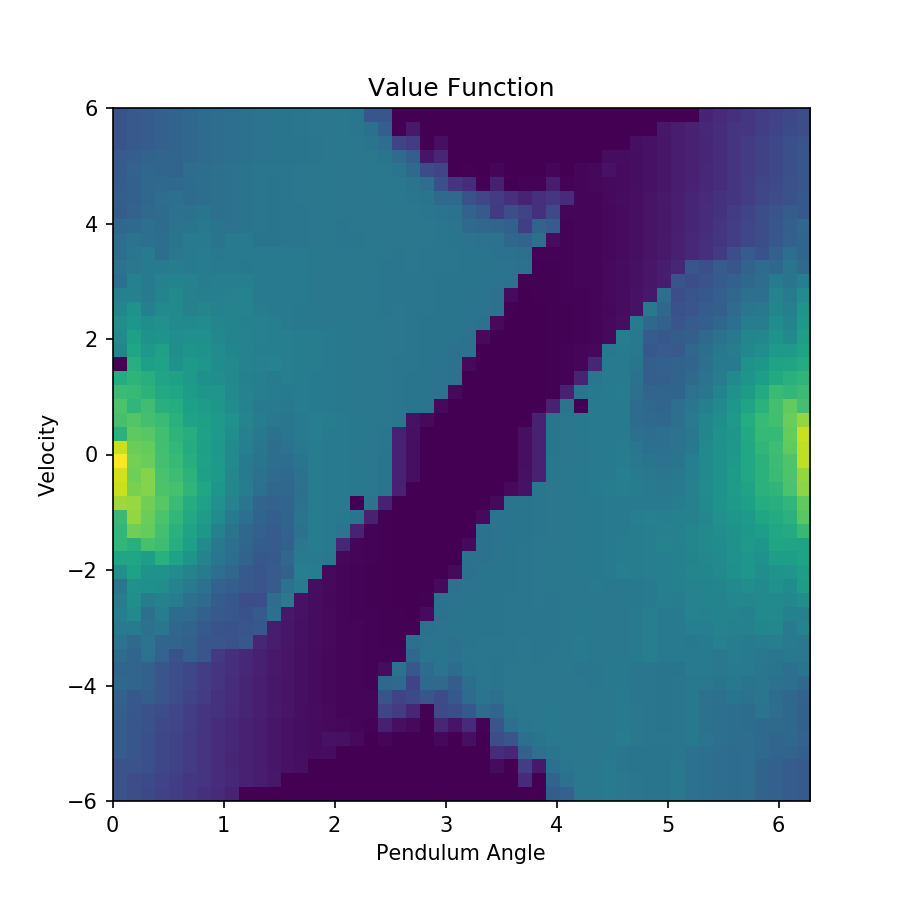

<IPython.core.display.Javascript object>


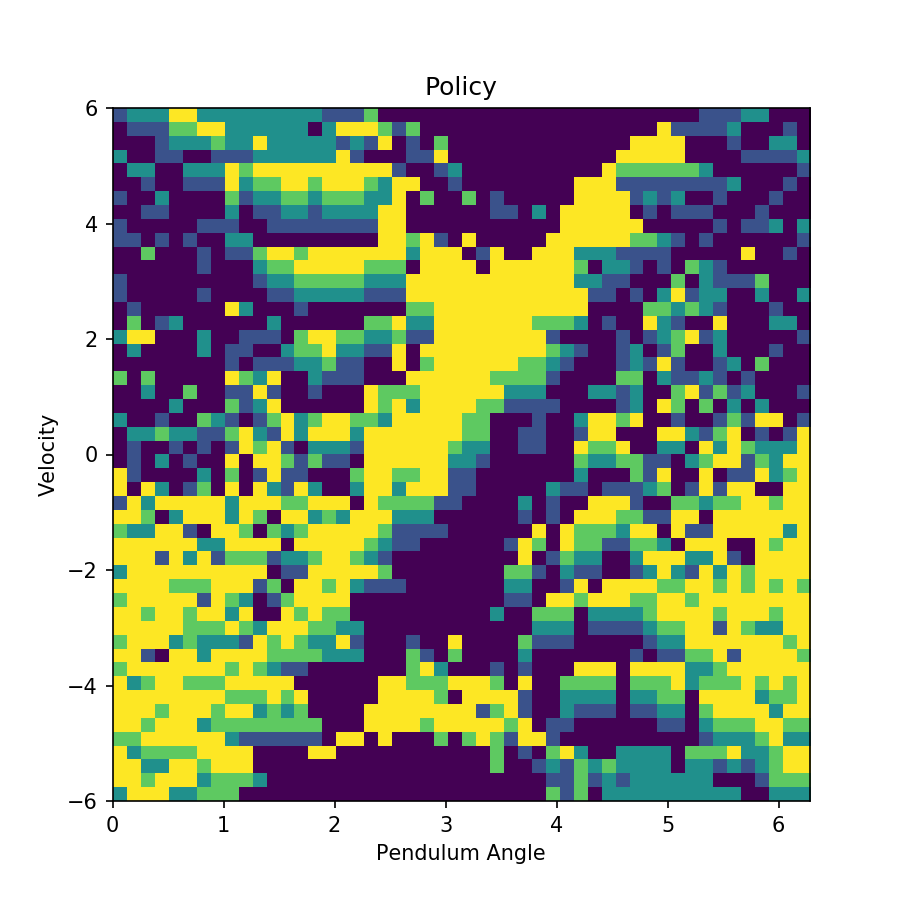

<IPython.core.display.Javascript object>


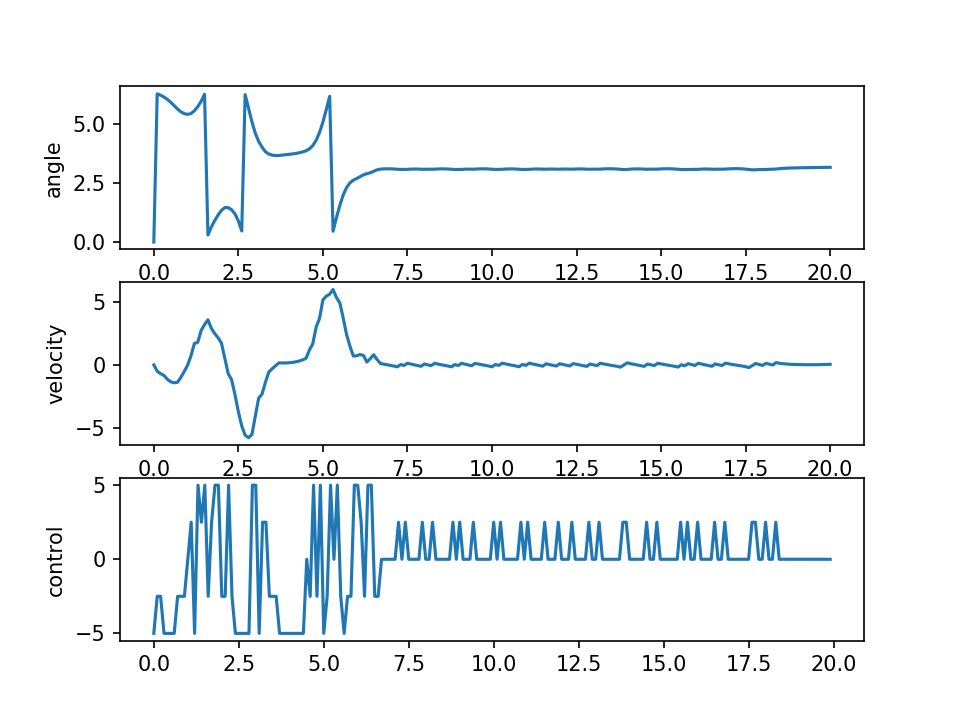

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAADON21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0dZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZYZCdC/yYgAABXwAsgZkmelx
SROADzDHsnTdNPwqh0IYXPcgsx/VdOgPtpJk3xmz25oQD2NxIJATjjPFHtCPYSSyrz7P5apm+qGo
CaO0hQa9TgblAkEBRtsbJoJjDfyhjQSKoxTNex2bKxAqRTNoM297EWxml92F4SgqAa9lbwbZ8+3M
8l0TfdHNaygcBuoe/stRvUXLZinWJDX2fTyHC+vsg7SSDh9VCALo/f8LntmbRMOk0qgXCi/HjrLA
aDHF+z18yVLK2z74iGw43VhNdJn7sOk6H3E21bAuxha9GcFT2B/gDsnAFBY5gBiZPeVxVbYpe4QY
u/Qkmk29MQ1rmTd5w6tt8rxwNyDWYzoDXLAPOxYEu0cWoQcXPjpp4iBWBfo93KDgq6XQij4Oj1LG
DzySMr38uhgbYXdV91VBopGTufKSekk2ZkKOtbq4Kr/zM9vviogAubMfy1/YSD/ic+Z6ysW11mqE
aw28fkE07LoVANnt98/WFOh2kP4qKS2EOW2R/aA3Z7G+ebWAmpyGawSKOP74xuxvFb5q1HlG8DH3
O6BFg3INvuHOb9LHOidxhtyJ3CtFzNDKZ6xn6mDvAAWWi6X5dO/wM3+9oH84RnZyXvVBZTxz37Y9
CWBZs8SWxmeLauVtCDCWXGmfqsrX46rQWMB47thgNvQfecfaBXLWPH/Ln589+UDsE4AAAAWhADNE
oRNMcgSX05dV4d0/PP9IcUUXL4xukpDOf0ubDcoYvQ7RDJhZ+wiC4WZJiSHmEmRnpAshUGY10zhc
ErFrHHS51CKt36JPfsRJMkhR28n0w3Su3PEyFB2m5TCheNgLMPw4UE2L3L9uZ9FmDgnwL+hxANUE
A3nKGncPO7+Tzh79ORxoU2uQjGQS6ftsKv+tNyGGjtkZmnJRPLl0FYbh78IT0U6XTNbC5fDi6hTW
2Yz0KdInsh8gtgzz4CQbLEvJgE38i/9ooA2f9dq0gY2Tm5aFImJPMtt2YPQ8xV9hqh0osQq83irK
UvYKvnPnwKiQx+RW/PClV91/xLbriOVxfJfXpRLewjagyH5geGIe7hinlehWzcuDnIEfJQEwu5oJ
lGygvQPsbZXbymoEr0pKDXheSfQiiooX5p//P1OXc1AtaIGXrmm6FLuE+3sC10tEJaNckjAoMOob
B4Fe6SoCJOgheojzoj1bjidnfx8rkuUpvPjQfyHbpwvlK8aedFAPWGJKJvoLYYEWEyI/sTXVVXwk
2y51QIvm2kQ1RvgIlmf4TDBkP80E1eB5qJ8rs4aw5P0H4sHh+/sNa0MDJqZh0uwQ2jS+HwZhSF0C
bpcCYdtdaKVUSjPHD1RNFG/jAX/pK6JSAOb4jZiP0tb/+W4P3vdlB0T6rB3Q9YKSD/Z+ZMu6f+wr
bjpb7Gu+S4EeTSncxiL1CMDFjEQn9kcXO4OxMn9kF7aEFsRgdLBoTLm81z2j5AbG52TO6n8KWBl/
wQJBdepWe9Lh5pwmoW9y1VRIAQJALUr/Axo5pP7z+HlCw7bD+XcceAIedT8sUYHC+tQ2YZpANUl2
BLTUIERl6z2OHmV1bEA1Sr+/gNkALX3zdrwVIeGWSi3gvDDgbH7GVej/i4IOwh1Tcx0Xh9hN5cLi
xIaOuvNfaaFhvupZAkjU1BA4DV74gi8djzi3RbTosfa/u++jXbjhsh5mXMnY8jqZOM72DJ3hhR+f
Ur8wPYq9XJKE6Efga6WHV4/qM+qgvsRWae+l/eBJlMaJ2wOYaS5L8LaU6XW9NhiAN2HXh5bwVgzR
dSwtsZ9sZovkEyVaFqYz9qbr93LiLFowFIUj/5Ety/m42pGzFPnp6aiUa1igh3TcQRebeMcs/m4r
HCcJ90+2m1BXequ+Fxsc7GXThhWXhB5NertML6XUrtZmW5UWB+sRLT1ch9hXIe2ILtvYtga/UzWh
JHPk9G567HoDGHWquKtSV4h8xjqxFj23AWQu8jwcnP1rTlu/gesgXKjdnFrICZS8E5QxH9Q3gEzR
CFXiE6ashkxLamCw022SOjhLtAFgqza3eJu3TYq22/AbqdMlkk/pm9nx2jLstm/2LCBgGrOvuyrw
uSWYuU9zxpU4C/OdVW9gVoMlBOBD43837CNt4H4eZEfNzqIqdYM9/mTh43EmoMMerQReBxwHJSBH
B7NOWLu5Wfij/8nNtRWVxDWXSIZZto+b4Uun3SMB4THXVlo6TOvDRm9O+BQkUlKN/L1Yd3fWWO/+
XpQobhgVHHR6I2F8K4zQvm2fYkCuqETHyA8k3/2odaDUOUN3bRI7uAGkoeSqbaQFf+ao9Rao1n21
H6yOdP++HN0VrfpXNQ5GQOZfucruGpsC5eAADewR6h+s6ABK96tBgK/4AAV4ANJO1tzJsDs7P2pR
uZM0BuRd5dWWO/GuV+u9kUSklnZi+Tw1+Z2KYAej1JaZ5hLv2tsi36rUQ4Ll+PUcGMxtLCyUUx6n
jxT2xqN+DEOGaLEB1O6iMpbREsu+oNjwz7Cf3hpvmr7EDbfTyECwevxXskYDot2bvKPXqXujUcpz
Us9pl4vjactj+5U+BU8H2ForpN1uySTIiTxIh7NS1V37l2G5b8idiTbt64Fg+Bggu3L0Q4x7JtZD
BP+nrhgee2tslRLc8+qwGzOntpHwyADKLtx+AVDeh3AaTzPatfSr2VttsC489yQgQSCEwdUx2scx
DxG3wWedND41VXHFeb8k6COxbCHOKusozNvVdSx3hkJiP/xxWGKpRZbHI8Irr0TwEs0FhT+bDSmk
vHzGZeTT7cIz5K4GuS0pPU5DMazlNv+0XdbSLyvnQS1K4XNPGEE/JfBX3nJtcV0m1o4mh2tCLz45
KVIWHdqTqcQo0Pfn/sGmC

In [17]:
# we instanciate a Q learning object for a pendulum model and a cost function
Q_Learning = QLearningTable(pendulum,cost,0.99,0.2,0.5)

# we run the iterations (with maximum number 2000).
Q_Learning.iterate(2000)

# we plot the results
plot_results(pendulum, Q_Learning.value_function, Q_Learning.policy, animate=True)